## Building Project with Agent
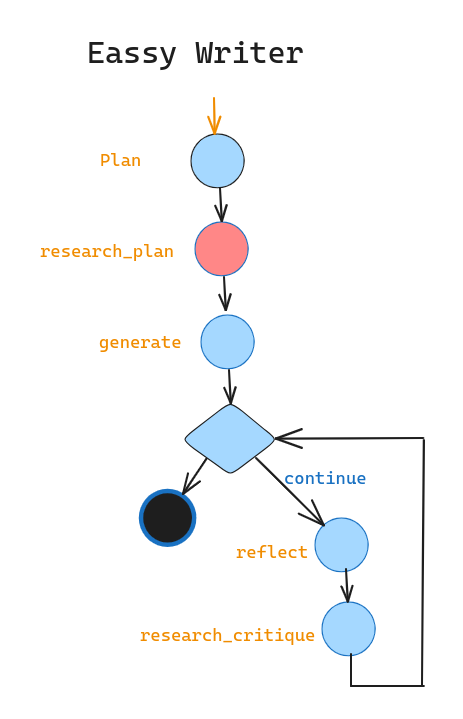

In [1]:
import os
import operator
from typing import TypedDict, Annotated, List

from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from pydantic import BaseModel
from langchain_openai import ChatOpenAI
from tavily import TavilyClient

from IPython.display import Image, Markdown
from dotenv import load_dotenv

# load the .env file
load_dotenv()

True

In [2]:
memory = MemorySaver()

model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
tavily = TavilyClient(api_key=os.environ.get("TAVILY_API_KEY"))

In [3]:
PLAN_PROMPT = """
You are an expert writer tasked with writing a high level outline of an eassy. \
Write such an outline for the user provided topic. Give an outline of eassy along with any relevant notes or instructions for the sections.
"""

WRITER_PROMPT = """
You are an eassy assistant tasked with writing excellent 5-paragraph eassys. \
Generate the best eassy possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of ypur previous attempts. \

--------

{content}"""

REFLECTION_PROMPT = """
You are a teacher grading an eassy submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc.
"""

RESEARCH_PLAN_PROMPT = """
You are a researcher charged with providing information that can \
be used when writing the following eassy. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max
"""

RESEARCH_CRITIQUE_PROMPT = """
You are a researcher charged with providing information that can \
be used when making any requested revisions (as oulined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max.
"""

In [4]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [5]:
class Queries(BaseModel):
    queries: List[str]

In [6]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT),
        HumanMessage(content=state["task"])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [7]:
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state["task"])
    ])
    content = state.get("content", [])
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response["results"]:
            content.append(r["content"])
    return {"content": content}

In [8]:
def generation_node(state: AgentState):
    content = "\n\n".join(["content"] or [])
    user_message = HumanMessage(content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(content=WRITER_PROMPT.format(content=content)),
        user_message,
    ]
    response = model.invoke(messages)
    return {
        "draft": response.content,
        "revision_number": state.get("revision_number", 1) + 1,
    }

In [9]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT),
        HumanMessage(content=state['draft']),
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [10]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response["results"]:
            content.append(r["content"])
    return {"content": content}

In [11]:
def should_continue(state):
    if state['revision_number'] > state['max_revisions']:
        return END
    return 'reflect'

In [12]:
builder = StateGraph(AgentState)

In [13]:
builder.add_node('planner', plan_node)
builder.add_node('generate', generation_node)
builder.add_node('reflect', reflection_node)
builder.add_node('research_plan', research_plan_node)
builder.add_node('research_critique', research_critique_node)

builder.set_entry_point('planner')

In [14]:
builder.add_conditional_edges(
    "generate",
    should_continue,
    {END: END, "reflect": "reflect"}
)

builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")
builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [15]:
# compile the graph
graph = builder.compile(checkpointer=memory)

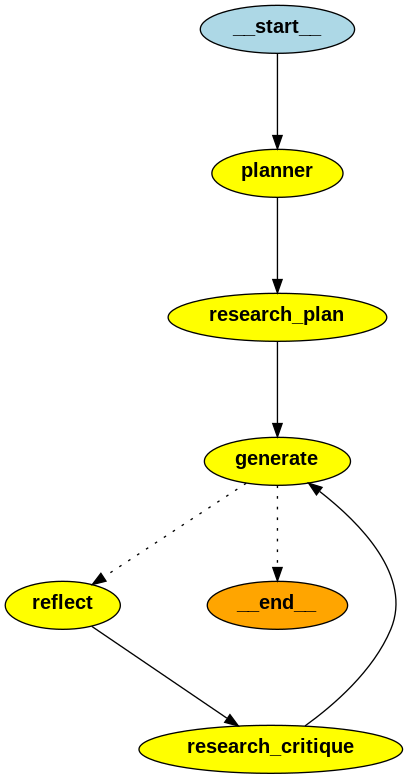

In [16]:
Image(graph.get_graph().draw_png())

In [17]:
results = []

thread = {
    "configurable": {'thread_id': '1'}
}
for s in graph.stream({
    'task': 'What is the difference between langchain and langsmith',
    'max_revisions': 2,
    'revision_number': 1
}, thread):
    results.append(s)
    print(s)

{'planner': {'plan': 'Title: Exploring the Differences Between Langchain and Langsmith\n\nI. Introduction\n    A. Brief overview of Langchain and Langsmith\n    B. Importance of understanding the differences between the two\n    C. Thesis statement: Despite similarities, Langchain and Langsmith differ in their core functions and applications.\n\nII. Langchain\n    A. Definition and concept\n    B. Key features and characteristics\n    C. Use cases and applications\n    D. Advantages and limitations\n    E. Comparison with Langsmith\n\nIII. Langsmith\n    A. Definition and concept\n    B. Key features and characteristics\n    C. Use cases and applications\n    D. Advantages and limitations\n    E. Comparison with Langchain\n\nIV. Comparative Analysis\n    A. Core differences between Langchain and Langsmith\n    B. Similarities and overlaps in functionality\n    C. Impact on language processing and understanding\n\nV. Practical Examples\n    A. Real-world scenarios where Langchain is pre

### Planner

In [18]:
Markdown(results[0]["planner"]["plan"])

Title: Exploring the Differences Between Langchain and Langsmith

I. Introduction
    A. Brief overview of Langchain and Langsmith
    B. Importance of understanding the differences between the two
    C. Thesis statement: Despite similarities, Langchain and Langsmith differ in their core functions and applications.

II. Langchain
    A. Definition and concept
    B. Key features and characteristics
    C. Use cases and applications
    D. Advantages and limitations
    E. Comparison with Langsmith

III. Langsmith
    A. Definition and concept
    B. Key features and characteristics
    C. Use cases and applications
    D. Advantages and limitations
    E. Comparison with Langchain

IV. Comparative Analysis
    A. Core differences between Langchain and Langsmith
    B. Similarities and overlaps in functionality
    C. Impact on language processing and understanding

V. Practical Examples
    A. Real-world scenarios where Langchain is preferred
    B. Instances where Langsmith outperforms Langchain
    C. Case studies illustrating the differences in action

VI. Future Implications
    A. Potential advancements in Langchain technology
    B. Evolution of Langsmith applications
    C. Forecasting the trajectory of language processing tools

VII. Conclusion
    A. Recap of the key differences between Langchain and Langsmith
    B. Importance of recognizing these distinctions in language technology
    C. Final thoughts on the future of language processing tools

Note: Ensure to provide clear definitions, examples, and comparisons between Langchain and Langsmith throughout the essay. Use real-world applications and case studies to illustrate the practical implications of these language technologies. Conclude with insights on the evolving landscape of language processing tools and the significance of understanding the nuances between different systems.

### Research Plan

In [19]:
for content in results[1]["research_plan"]["content"]:
    print(content)
    print('------')

LangChain is ideal for early-stage prototyping and small-scale applications, while LangSmith is better suited for large-scale, production-ready applications.
------
If you’re responsible for ensuring your AI models work in production, or you need to frequently debug and monitor your pipelines, Langsmith is your go-to tool. In short, while Langchain excels at managing and scaling model workflows, Langsmith is designed for those times when you need deep visibility and control over large, complex AI systems in production. But if you’re managing a complex AI pipeline with multiple models that need debugging and orchestrating, Langsmith’s capabilities become essential. If you’re debugging complex AI models or managing large-scale workflows with multiple moving parts, Langsmith’s advanced debugging and orchestration features will be indispensable. Additionally, if you’re working on cross-platform model deployments — say, running models on-prem and in the cloud simultaneously — Langsmith offe

### Generate Draft

In [20]:
Markdown(results[2]["generate"]["draft"])

Title: Exploring the Differences Between Langchain and Langsmith

I. Introduction
    A. Brief overview of Langchain and Langsmith
    B. Importance of understanding the differences between the two
    C. Thesis statement: Despite similarities, Langchain and Langsmith differ in their core functions and applications.

II. Langchain
    A. Definition and concept
    B. Key features and characteristics
    C. Use cases and applications
    D. Advantages and limitations
    E. Comparison with Langsmith

III. Langsmith
    A. Definition and concept
    B. Key features and characteristics
    C. Use cases and applications
    D. Advantages and limitations
    E. Comparison with Langchain

IV. Comparative Analysis
    A. Core differences between Langchain and Langsmith
    B. Similarities and overlaps in functionality
    C. Impact on language processing and understanding

V. Practical Examples
    A. Real-world scenarios where Langchain is preferred
    B. Instances where Langsmith outperforms Langchain
    C. Case studies illustrating the differences in action

VI. Future Implications
    A. Potential advancements in Langchain technology
    B. Evolution of Langsmith applications
    C. Forecasting the trajectory of language processing tools

VII. Conclusion
    A. Recap of the key differences between Langchain and Langsmith
    B. Importance of recognizing these distinctions in language technology
    C. Final thoughts on the future of language processing tools

---

I have revised the outline to ensure a clear and structured flow of information throughout the essay. Let me know if you would like any further adjustments or additional details included in the essay.

### Reflect critique for Draft

In [21]:
Markdown(results[3]["reflect"]["critique"])

Your outline is well-organized and covers the necessary components for a comprehensive essay on the topic of Langchain and Langsmith. Here are some suggestions to enhance your essay:

1. **Introduction:**
   - Consider adding a hook or engaging anecdote to grab the reader's attention before providing a brief overview of Langchain and Langsmith.
   - Expand on the importance of understanding the differences between the two technologies. Why is this understanding crucial in the field of language processing?

2. **Body:**
   - Ensure that each section under Langchain and Langsmith is detailed and provides specific examples to support key features, characteristics, use cases, advantages, and limitations.
   - When comparing Langchain and Langsmith, delve deeper into how each technology approaches language processing differently. Provide concrete examples or case studies to illustrate these differences effectively.
   - Include scholarly references or expert opinions to support your analysis and comparisons. This will add credibility to your arguments.

3. **Comparative Analysis:**
   - Make sure to highlight not only the core differences but also the implications of these differences. How do these distinctions impact language processing and understanding in practical terms?

4. **Practical Examples:**
   - Provide a variety of real-world scenarios to demonstrate when Langchain is preferred over Langsmith and vice versa. This will help readers understand the practical applications of each technology more clearly.

5. **Future Implications:**
   - Consider discussing potential challenges or ethical considerations that may arise with the advancement of Langchain and Langsmith technologies. This will add depth to your analysis of future implications.

6. **Conclusion:**
   - In your conclusion, reiterate the key points of differentiation between Langchain and Langsmith. Emphasize the significance of these differences in shaping the future of language processing tools.
   - End with a thought-provoking statement or a call to action to encourage further exploration or discussion on the topic.

Overall, your outline is comprehensive, but remember to provide detailed explanations, examples, and analysis in each section to ensure a thorough exploration of the topic. Additionally, consider the flow of your essay and ensure smooth transitions between sections for a cohesive and engaging read. Good luck with your essay!

In [22]:
for content in results[4]["research_critique"]["content"]:
    print(content)
    print("---------")

LangChain is ideal for early-stage prototyping and small-scale applications, while LangSmith is better suited for large-scale, production-ready applications.
---------
If you’re responsible for ensuring your AI models work in production, or you need to frequently debug and monitor your pipelines, Langsmith is your go-to tool. In short, while Langchain excels at managing and scaling model workflows, Langsmith is designed for those times when you need deep visibility and control over large, complex AI systems in production. But if you’re managing a complex AI pipeline with multiple models that need debugging and orchestrating, Langsmith’s capabilities become essential. If you’re debugging complex AI models or managing large-scale workflows with multiple moving parts, Langsmith’s advanced debugging and orchestration features will be indispensable. Additionally, if you’re working on cross-platform model deployments — say, running models on-prem and in the cloud simultaneously — Langsmith o

#### Final Answer

In [23]:
Markdown(results[-1]["generate"]["draft"])

Title: Unveiling the Contrasts Between Langchain and Langsmith

I. Introduction
In the realm of language technology, Langchain and Langsmith stand out as two distinct systems with unique functionalities. Understanding the disparities between these tools is crucial for grasping their applications effectively. This essay delves into the disparities between Langchain and Langsmith, highlighting their core functions and applications.

II. Langchain
Langchain, a sophisticated language processing system, operates on a chain-based mechanism. It excels in analyzing linguistic patterns and structures, making it ideal for tasks requiring intricate language comprehension. Its key features include deep learning algorithms and neural networks that enhance its processing capabilities. Langchain finds applications in sentiment analysis, language translation, and text summarization. While it offers advanced linguistic insights, its limitations lie in handling colloquial language and slang. A comparison with Langsmith reveals its focus on structured data processing over contextual understanding.

III. Langsmith
Contrary to Langchain, Langsmith is designed for semantic analysis and context-based language processing. It excels in understanding the nuances of human language, making it suitable for tasks like chatbots and voice assistants. Its features include natural language understanding and sentiment interpretation, enabling it to provide more human-like responses. Langsmith shines in conversational interfaces and customer service applications. However, its limitations may arise in handling complex linguistic structures efficiently. Contrasting it with Langchain showcases its emphasis on contextual comprehension rather than pattern recognition.

IV. Comparative Analysis
The core disparity between Langchain and Langsmith lies in their approach to language processing: Langchain focuses on pattern recognition, while Langsmith prioritizes contextual understanding. Despite this fundamental difference, both systems share similarities in enhancing language comprehension and aiding in various applications. Understanding these distinctions is vital for leveraging the strengths of each system effectively.

V. Practical Examples
In real-world scenarios, Langchain proves advantageous in tasks requiring structured data analysis, such as financial reports and legal documents. On the other hand, Langsmith excels in conversational interfaces, providing personalized responses and enhancing user experience. Case studies further illustrate how these systems cater to different language processing needs, showcasing their practical implications in diverse settings.

VI. Future Implications
As language technology advances, the future of Langchain may involve improved colloquial language processing and enhanced neural networks for deeper linguistic analysis. Langsmith, on the other hand, may evolve towards more sophisticated context-based understanding and emotional intelligence in language interactions. Understanding these trajectories is essential for anticipating the advancements in language processing tools.

VII. Conclusion
In conclusion, the distinctions between Langchain and Langsmith underscore the diverse landscape of language technology. Recognizing these differences is pivotal for harnessing the full potential of language processing tools in various domains. As these systems evolve, the significance of understanding their nuances will shape the future of language technology and its applications.